# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Homework 9:  ANNs


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>


<hr style="height:2pt">



In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Import libraries:

In [1]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import keras 
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from keras import regularizers


from sklearn.utils import shuffle
import warnings

warnings.filterwarnings('ignore')

E:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<hr style='height:2pt'>
<div class='theme'> Neural Networks </div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In symbols: $ \cal{F(s)} = \int_{-\infty}^\infty f(x)e^{-2\pi i xs}dx$. In words, the value of the transformed function at some point, $s$, is the value of an integral which measures, in some sense, how much the original f(x) looks like a wave with period s. As an example, with $f(x) = 4cos(x) + sin(2x)$,  $\cal{F}(s)$ is 0 everywhere except at -2, -1, 1, and 2, mapping to the waves of period 1 and 1/2. The values at these points are linked to the magnitude of the waves, and their phases (roughly: sin waves versus cosine waves).

The only thing about the Fourier transform that matters for this pset is this: function goes in, re-write in terms of sine and cosine comes out.

In our specific problem, we'll train a network to map from 1000 sample values from a function (equally spaced along 0 to 2$\pi$) to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4.

Questions 1.1 and 1.2 will get you used to the format of the data.

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> <b> Question 1 [50pts] <b> </div>
**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve.

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**1.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [2]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [349]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

### Answers:  

**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

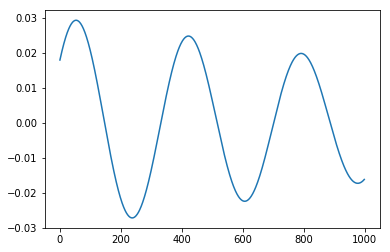

In [350]:
# your code here
plt.plot(X_train[0])

From the graph, we can see that the first sample of x_train is a sinusoidal curve. 

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

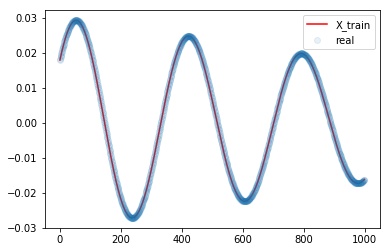

In [351]:
# your code here
x=np.arange(0,10*math.pi,0.01*math.pi)
y=np.zeros(len(x))
for i in range(0,len(x)):
    y[i]=0.024*math.sin(0.533*x[i])+0.018*math.cos(0.558*x[i])
plt.plot(X_train[0],'r',label='X_train')
plt.plot(y,'o',alpha=0.1,label='real')
plt.legend()

From the graph, we can see that two curves are overlaid totally, thus we can verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$.

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [352]:
# your code here
model=Sequential()
model.add(Dense(200, input_dim=1000,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(4,activation='linear'))

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [353]:
# your code here
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_569 (Dense)            (None, 200)               200200    
_________________________________________________________________
dense_570 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_571 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_572 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_573 (Dense)            (None, 4)                 44        
Total params: 231,454
Trainable params: 231,454
Non-trainable params: 0
_________________________________________________________________


-
Your answer here

Since one input vector has 1000 sample values, and for the first layer we have 200 nodes predict the result under the combination of 1000 sample values, thus for each node in the first layer, we need 1000 input parameters plus one constant bias parameter to adjust the output for that node, thus need we have (1000+1)*200=200200  parameters to describe the situations of first layer nodes.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [354]:
# your code here
model.fit(X_train, y_train,epochs=50,
          batch_size=32, validation_split=0.2,verbose=0)

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

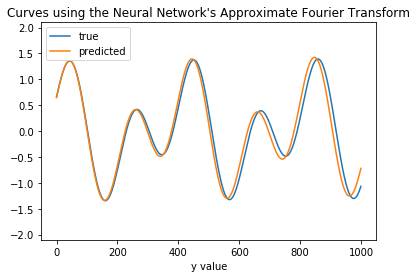

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.8697264  0.996384   0.6480861  0.49083483]


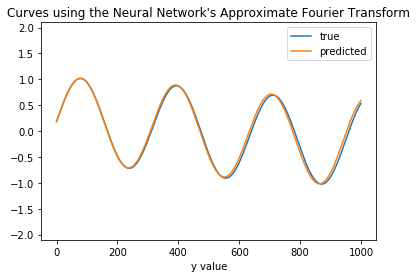

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.8402473  0.636899   0.18459773 0.10535775]


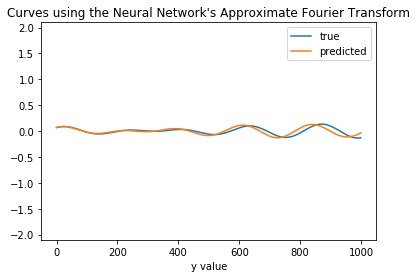

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.06302609 0.76558393 0.06749857 0.9583207 ]


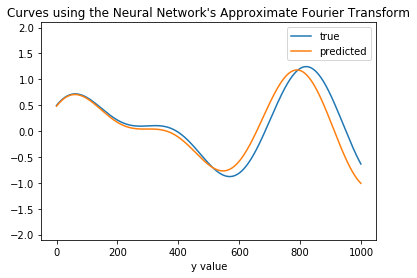

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.7316745  0.32578123 0.48106152 0.49720985]


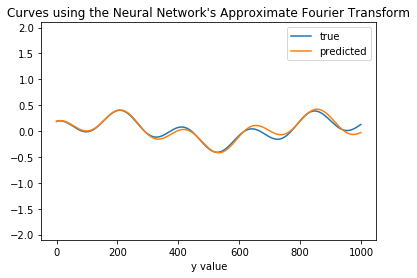

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.23490776 0.29159403 0.18802637 0.9344247 ]


In [9]:
# your code here
plot_predictions(model, X_test, y_test, count=None)

In [10]:
test_score=model.evaluate(X_test, y_test,verbose=1)
print (f'the test set overall loss is:{test_score}.')

2000/2000 [==============================] - 0s 38us/step
the test set overall loss is:0.025614867150783538.


----
Your answer here

From the plots we generated using the true data and the models we generated from the NN, we can see that they are overlaid each other almost totally for each case, thus the NN model predicts the unseen data very well. And I think the model has accurately learned how to map from the sample data to the coefecient that generated the data, by using this training set.

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

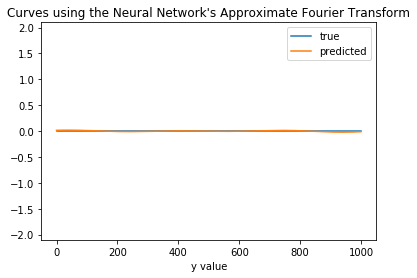

true: [0. 0. 0. 0.]
predicted: [0.01176637 0.40302834 0.01462862 0.5151015 ]


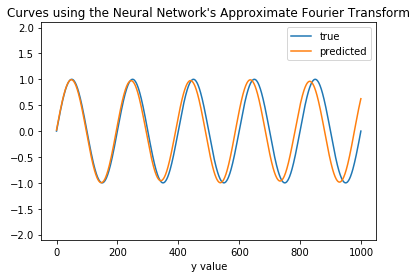

true: [1. 1. 0. 0.]
predicted: [0.9786483  1.0213783  0.02035352 0.5798764 ]


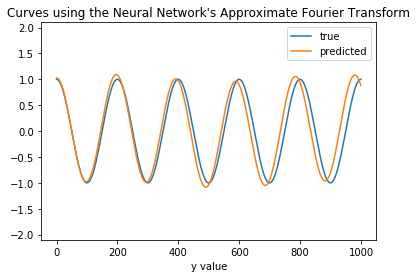

true: [0. 0. 1. 1.]
predicted: [0.06621584 0.27406654 1.0255383  1.0197939 ]


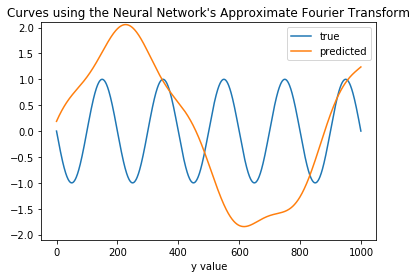

true: [-1.  1.  0.  0.]
predicted: [1.8712966  0.22536588 0.18802878 0.8677525 ]


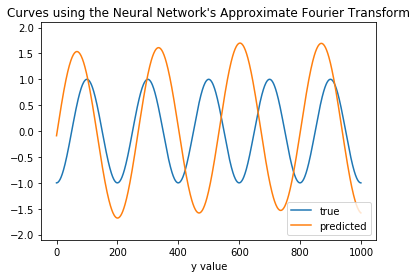

true: [ 0.  0. -1.  1.]
predicted: [ 1.6219044   0.74676144 -0.08971813  0.13809727]


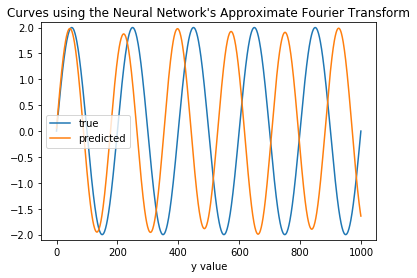

true: [2. 1. 0. 0.]
predicted: [1.9342554  1.1324935  0.05767196 0.44581312]


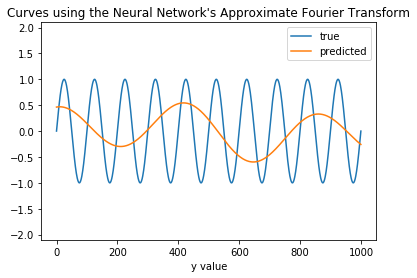

true: [1. 2. 0. 0.]
predicted: [0.17045636 0.19980828 0.4637011  0.46868038]


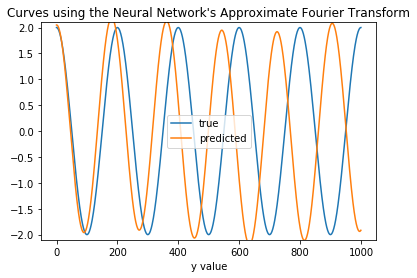

true: [0. 0. 2. 1.]
predicted: [0.14710651 0.22853175 2.0495205  1.1043106 ]


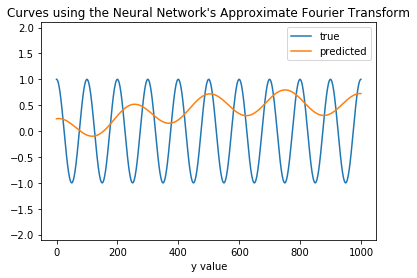

true: [0. 0. 1. 2.]
predicted: [0.55660284 0.06609422 0.2381784  0.7988772 ]


In [11]:
# your code here
plot_predictions(model, X_extended_test, y_extended_test, count=None)

----
Your answer here
Form the plots we generated, we can see that the model preformed well on first, second, and the third case, with almost all parts are overlaid each other for the true data and predicted data. However, the other cases are predicted very bad, especially when the true coefficients are [-1.  1.  0.  0.],[1. 2. 0. 0.],[0. 0. 1. 2.], and the difference are very large.

**1.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

----
Your answer here

From the plots we generated, we can see that all the difficult obsevations have high periodicity, and the data use to predict may replicated with same y-values, however, the data we used to train the model doesn't have such observations with many replicated values, thus the model may predicts different periods functions with same values, thus the result are not good. Another reason is, we can see that all the difficult observations are only one single triangular function, with the other one equal to 0, and it is very difficult for our model to predict these kind of model since the train set doesn't have such extreme cases. Thus, the model is underfit because it can't predict the parameters of the function correctly, and the model didn't learn the mapping we had in mind.

<hr style='height:2pt'>

## Regulrizing Neural Networks

In this problem set we have already explored how ANN are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size), and how well the neural network can generalize. In this problem we focus on issues of overfitting and regularization in Neural Networks.

As we have explained in class, ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns don't generalize to fresh data.

There are several methods used to improve ANN generalization. One approach is to use an achitecutre just barely wide/deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and computationally costly to hunt for a correct size. Given this, other methodologies are used to fight overfitting and improve the ANN generalization. These, like other techniques to combat overfitting, fall under the umbrella of Regularization.

In this problem you are asked to regularize a network given to you below. The train dataset can be generated using the code also given below. 




<div class='exercise'> <b> Question 2 [50 pts] </b> </div>


**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU 
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 2,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

We will evaluate your model on a test set we've kept secret. 

1. Don't try to use extra data from NMIST. We will re-train your model on training set under the settings above. 
2. Keep the  architecture above as is. In other words keep the number of layers, number of nodes, activation function, and loss fucntion the same. You can change the number of epochs (max 2000), batch size, optimizer and of course add elements that can help to regularize (e.g. drop out, L2 norm etc). You can also do data augmentation. 
3. You *may* import new modules, following the citation rule above.

Grading: Your score will be based on how much you can improve on the test score via regularization:
1.  (0-1] percent will result into 10 pts
2.  (1-2] percent will result into 20 pts
3.  (2-3] percent will result into 30 pts
4.   Above 3 percent will result in 35 pts
6.   Top 15 groups or single students will be awarded an additional 10 pts
7.   The overall winner(s) will be awarded an additional 5 pts

**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

In [161]:
## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

#shuffle the data before we do anything
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [162]:
## separating 4s and 9s select 800 points 
# your code here 
x_train_4=x_train[y_train==4]
x_train_9=x_train[y_train==9]
y_train_4=y_train[y_train==4]
y_train_9=y_train[y_train==9]


In [163]:
x_train_49=np.vstack((x_train_4[0:400],x_train_9[0:400]))
y_train_49=np.hstack((y_train_4[0:400],y_train_9[0:400]))
x_train_use,y_train_use=shuffle(x_train_49,y_train_49,random_state=1)
y_train_use[y_train_use==4]=1
y_train_use[y_train_use==9]=0
y_train_use.shape

(800,)

In [164]:
# Preprocess data using keras.utils.to_categorical
# your code here 
y_train_use_cat=keras.utils.to_categorical(y_train_use)

In [165]:
# scale the data otherwise reLU can become unstable 
# your code here 
x_train_use_scale=keras.utils.normalize(x_train_use)

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

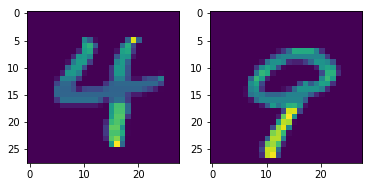

In [149]:
# your code here

plt.subplot(1,2,1)
plt.imshow(x_train_use_scale[0])
plt.subplot(1,2,2)
plt.imshow(x_train_use_scale[1])

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 1,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

In [338]:
# your code here
model1=Sequential()
model1.add(keras.layers.Flatten(input_shape=(28, 28)))
model1.add(Dense(100,activation='relu'))
model1.add(Dense(100,activation='relu'))
model1.add(Dense(100,activation='relu'))
model1.add(Dense(2,activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model1_fit=model1.fit(x_train_use_scale, y_train_use_cat,epochs=1000,
          batch_size=128, validation_split=0.5,verbose=0)


Text(0.5,1,'Model Accurarcy in Different Sets across Epochs')

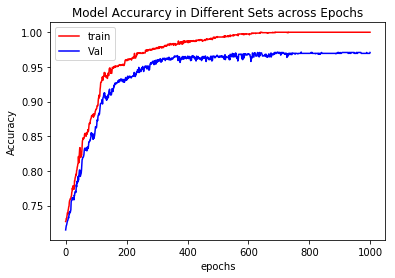

In [339]:
#your code here
plt.plot(np.sqrt(model1_fit.history['acc']), 'r', label='train')
plt.plot(np.sqrt(model1_fit.history['val_acc']), 'b' ,label='Val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Model Accurarcy in Different Sets across Epochs')

In [340]:
##test set modification

x_test_4=x_test[y_test==4]
x_test_9=x_test[y_test==9]
y_test_4=y_test[y_test==4]
y_test_9=y_test[y_test==9]
x_test_49=np.vstack((x_test_4,x_test_9))
y_test_49=np.hstack((y_test_4,y_test_9))
x_test_use,y_test_use=shuffle(x_test_49,y_test_49,random_state=1)
y_test_use[y_test_use==4]=1
y_test_use[y_test_use==9]=0
y_test_use_cat=keras.utils.to_categorical(y_test_use)
x_test_use_scale=keras.utils.normalize(x_test_use)

## test accuracy score
print(f'The test accuracy score is {accuracy_score(y_test_use_cat.argmax(axis=1),model1.predict(x_test_use_scale).argmax(axis=1))}')

The test accuracy score is 0.9377197388247112


<hr>

Your answer here

As we can see from the plot, although the accuracy on the train set is approaching to 1 as the epochs increasing, the accuracy on the validation set started fluctuating around 0.93 when the epochs is larger than 250, and the loss on the validation is not decreasing after 250 epochs with loss on the train set is almost 0 when epoch is 1000. Since the accuracy on the train set is 1 with no improve on the validation accuracy when epoch is larger than 250, we can say that the model is overfit.

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

In [325]:
# your code here
#earlystopping and regularizers
from keras.callbacks import EarlyStopping
from keras import regularizers
early_stopping_monitor = EarlyStopping(patience=20)

#Dropout and Gaussian nosie
from keras.layers import Dropout, GaussianNoise
#image augment
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                             rotation_range=90,horizontal_flip=True, vertical_flip=True,
                            width_shift_range=0.2, height_shift_range=0.2,zca_whitening=True,
                             zoom_range=0.2)
x_train_use_scale_mod=x_train_use_scale.reshape(x_train_use_scale.shape[0],1,28,28)
x_test_use_scale_mod=x_test_use_scale.reshape(x_test_use_scale.shape[0],1,28,28)   
##please use this modified test_set form to perform testing


datagen.fit(x_train_use_scale_mod)




In [344]:
#model building
model_reg=Sequential()

model_reg.add(keras.layers.Flatten(input_shape=(1,28, 28)))
model_reg.add(Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.003),
                   activity_regularizer=regularizers.l1(0.000001)))

model_reg.add(keras.layers.Dropout(0.2))
model_reg.add(Dense(100,activation='relu'))
model_reg.add(GaussianNoise(0.2))
model_reg.add(keras.layers.Dropout(0.5))
model_reg.add(Dense(100,activation='relu'))
model_reg.add(keras.layers.Dropout(0.5))
model_reg.add(Dense(2,activation='sigmoid'))
model_reg.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

model_reg_fit=model_reg.fit(x_train_use_scale_mod, y_train_use_cat,epochs=2000,
            batch_size=128, validation_split=0.20, callbacks=[early_stopping_monitor],verbose=0)
    
p=accuracy_score(y_test_use_cat.argmax(axis=1),model_reg.predict(x_test_use_scale_mod).argmax(axis=1))
##please use this modified test_set form to perform testing

Text(0.5,1,'Model Accurarcy in Different Sets across Epochs')

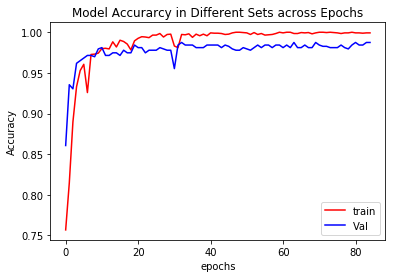

In [345]:
plt.plot(np.sqrt(model_reg_fit.history['acc']), 'r', label='train')
plt.plot(np.sqrt(model_reg_fit.history['val_acc']), 'b' ,label='Val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Model Accurarcy in Different Sets across Epochs')

In [347]:
## test accuracy score
print(f'The test accuracy score is {accuracy_score(y_test_use_cat.argmax(axis=1),model_reg.predict(x_test_use_scale_mod).argmax(axis=1))}.')


The test accuracy score is 0.9688598694123556.


In [335]:
model_reg.save('model196_885')

Explanation:
In the model I modified, I use the L1 L2 norm regularizers on the first layer of the neural networks, and the value are came from cross-validation. In order to introduce more general train set to the model, I use the imagedatagenerator to do the image augmentation. In the model building, I also introduce the gaussian noise to the input layer, and introduce droppout to each layer to eliminate the noise nodes which doesn't participate the prediction too much. Also, I added an earlystopping to the model fitting which can stop the training when the evidence of overfitting shows. By doing this, my model has a best 96.89% test accuracy, which is 3.2% increase comparing to the model in 2.3, which is much better.

**note:** When testing the model, please modify the test data by using:  
x_test_use_scale=keras.utils.normalize(x_test), and   
x_test_use_scale_mod=x_test_use_scale.reshape(x_test_use_scale.shape[0],1,28,28)   
to generate the test data which can be used for predictions. 